<a href="#Import"> 1. Import Dependencies </a><br>
<a href="#Validate"> 2. Validate Data </a><br>
<a href="#Prune"> 3. Prune Data</a><br>
<a href="#ML"> 4. Machine Learning </a>

<hr>

## 1. Import Dependencies <a id='Import'></a>

In [178]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

from mongoHandler import mongoHandler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import shap


In [179]:
#mongoHandler = mongoHandler()
#mongoHandler.pullMongoDB("pastdata.csv")

## 2. Validate Data <a id=Validate></a>

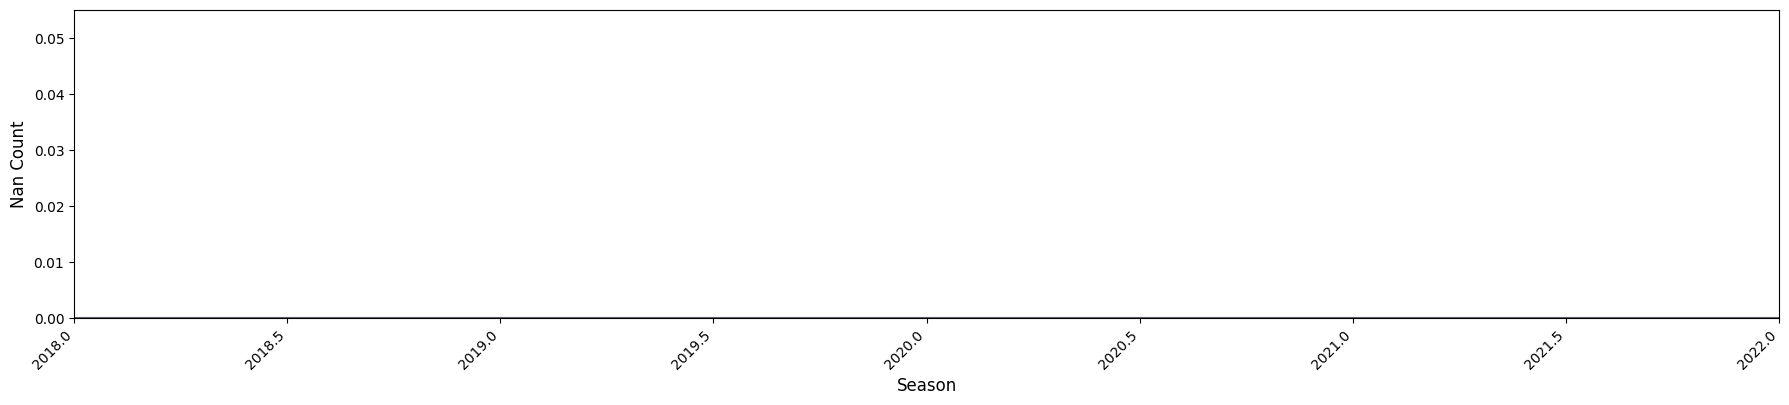

In [180]:
# This is optional as our data does not have any null values, but may be useful for other data sets
df = pd.read_csv("pastdata.csv")
prediction = pd.read_csv('2023data.csv')
df_detail_nan = []

for season in df['season'].unique():
    df_nan = df[df['season'] == season]
    series_nan = df_nan.isnull().sum()
    df_nan = series_nan.to_frame(name="Nan_Count")
    df_nan = df_nan.rename_axis('Col_Name').reset_index()
    df_nan['season'] = season
    df_detail_nan.append(df_nan)

df_detail_nan = pd.concat(df_detail_nan, ignore_index=True)

df_per_season_nan = df_detail_nan[['season','Nan_Count']].groupby("season").sum().reset_index()
df_per_season_nan = df_per_season_nan.sort_values(by=['season'], ascending=True)

fig = plt.figure(figsize = (22, 4))
sns.lineplot(data=df_per_season_nan, x="season", y="Nan_Count", sort=True)
plt.ylim(0)
plt.ylabel('Nan Count', fontsize=12)
plt.xticks(rotation=45,horizontalalignment='right',fontweight='light', fontsize=10)
plt.xlabel('Season', fontsize=12)
plt.margins(x=0)
plt.show()

## 3. Prune Data <a id="Prune">

In [181]:
# These stats are either duplicates or not useful for our analysis
STATS_TO_DROP = ['gk_clean_sheets_pct',
    'players_used', 'games', 'games_starts', 'minutes', 'minutes_90s', 'goals', 'assists',
    'goals_assists', 'goals_pens', 'pens_made', 'pens_att', 'cards_yellow', 
    'cards_red','xg', 'npxg','xg_assist', 'npxg_xg_assist', 'gk_games', 
    'gk_games_starts', 'gk_minutes','gk_goals_against', 'gk_saves', 'gk_wins', 
    'gk_ties', 'gk_losses','gk_clean_sheets', 'gk_pens_att', 'gk_pens_allowed', 
    'gk_pens_saved', 'gk_pens_missed', 'gk_psxg_net', 'gk_passes_completed_launched',
    'gk_passes_launched', 'gk_crosses_stopped', 'gk_def_actions_outside_pen_area',
    'shots', 'shots_on_target', 'sca', 'gca'
]

# These stats are too representative of the amount of games played, leading to skewed results.
# Thus we convert them to per 90 stats.
STATS_TO_PER90 = [
    'progressive_carries', 'progressive_passes', 'gk_free_kick_goals_against', 
    'gk_corner_kick_goals_against', 'gk_own_goals_against', 'gk_psxg', 'gk_passes', 
    'gk_passes_throws', 'gk_goal_kicks', 'gk_crosses', 'xg_net', 'npxg_net', 'passes_completed', 
    'passes_total_distance', 'passes_progressive_distance', 'passes', 'passes_completed_short',
    'passes_short', 'passes_completed_medium', 'passes_medium', 'passes_completed_long',
    'passes_long', 'pass_xa', 'xg_assist_net', 'assisted_shots', 'passes_into_final_third',
    'passes_into_penalty_area', 'crosses_into_penalty_area', 'passes_live', 'passes_dead',
    'passes_free_kicks', 'through_balls', 'passes_switches', 'crosses', 'throw_ins',
    'corner_kicks', 'corner_kicks_in', 'corner_kicks_out', 'corner_kicks_straight',
    'passes_offsides', 'passes_blocked', 'sca_passes_live', 'sca_passes_dead',
    'sca_take_ons', 'sca_shots', 'sca_fouled', 'sca_defense', 'gca_passes_live',
    'gca_passes_dead', 'gca_take_ons', 'gca_shots', 'gca_fouled', 'gca_defense',
    'tackles', 'tackles_won', 'tackles_def_3rd', 'tackles_mid_3rd', 'tackles_att_3rd',
    'challenge_tackles', 'challenges', 'challenges_lost', 'blocks', 'blocked_shots',
    'blocked_passes', 'interceptions', 'tackles_interceptions', 'clearances', 'errors',
    'touches', 'touches_def_pen_area', 'touches_def_3rd', 'touches_mid_3rd', 'touches_att_3rd',
    'touches_att_pen_area', 'touches_live_ball', 'take_ons', 'take_ons_won',
    'take_ons_tackled', 'carries', 'carries_distance', 'carries_progressive_distance',
    'carries_into_final_third', 'carries_into_penalty_area', 'miscontrols', 'dispossessed',
    'passes_received', 'progressive_passes_received', 'cards_yellow_red', 'fouls', 'fouled',
    'offsides', 'pens_won', 'pens_conceded', 'own_goals', 'ball_recoveries', 'aerials_won',
    'aerials_lost'
]



In [182]:
df[STATS_TO_PER90] = df[STATS_TO_PER90].div(df['minutes_90s'], axis=0)
prediction[STATS_TO_PER90] = prediction[STATS_TO_PER90].div(prediction['minutes_90s'], axis=0)
df.drop(columns=STATS_TO_DROP, inplace=True)
prediction.drop(columns=STATS_TO_DROP, inplace=True)

In [183]:
df = df.rename(columns={col: col + '_per90' for col in STATS_TO_PER90})
prediction = prediction.rename(columns={col: col + '_per90' for col in STATS_TO_PER90})

## 4. Machine Learning <a id="ML"></a>

In [184]:
target = df['standing']
features = df.drop(['standing','team'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
#model = RandomForestClassifier()
#model = RandomForestRegressor()
model = XGBRegressor()
model.fit(X_train, y_train)

#y_pred_prob = model.predict_proba(X_test)

y_pred = model.predict(X_test)

probabilities = np.exp(-y_pred)
probabilities /= np.sum(probabilities)

#first_place_probabilities = y_pred_prob[:, 0]
print(f"First Place Probabilities (Test Data): {', '.join(map(str, probabilities*100))}")

#print(f"Test Prediction: {', '.join(map(str, y_pred))}")

First Place Probabilities (Test Data): 0.06499041, 0.9610732, 37.210213, 46.331894, 9.15544e-05, 6.49052e-05, 0.030788278, 0.058528893, 0.046079826, 0.07572843, 0.84825176, 0.49388534, 4.6960467e-05, 0.021638907, 0.0022377737, 8.495125e-05, 5.6771358e-05, 0.05256763, 0.17888367, 5.8670673, 7.751618e-05, 3.9533817e-05, 0.007108511, 0.00018912961, 0.009564006, 0.014385341, 1.2807772, 1.4065421, 4.8514895, 0.185438, 0.0001000081, 0.000111306734


In [185]:
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
print(f"MAE: {MAE.round(4)}")
print(f"MSE: {MSE.round(4)}")

MAE: 2.7088
MSE: 14.2942


In [186]:
predictionWithTeam = prediction.copy()
prediction = prediction.drop(['team'],axis=1)

y_pred2 = model.predict(prediction)

probabilitiesPrediction = np.exp(-y_pred2)
probabilitiesPrediction /= np.sum(probabilitiesPrediction)

team_probabilities = zip(predictionWithTeam['team'], probabilitiesPrediction)
sorted_team_probabilities = sorted(team_probabilities, key=lambda x: x[1], reverse=True)
formatted_output = "\n".join([f"{team}: {prob*100:.2f}%" for team, prob in sorted_team_probabilities])

print("First Place Probabilities (2023):")
print(formatted_output)


First Place Probabilities (2023):
Manchester City: 74.55%
Real Madrid: 11.69%
Inter: 5.96%
Napoli: 3.86%
Liverpool: 1.14%
Dortmund: 1.11%
Paris S-G: 0.72%
Benfica: 0.45%
RB Salzburg: 0.15%
Juventus: 0.12%
Bayern Munich: 0.10%
Barcelona: 0.04%
Porto: 0.03%
RB Leipzig: 0.02%
Chelsea: 0.01%
Club Brugge: 0.01%
Shakhtar: 0.01%
Milan: 0.01%
Sporting CP: 0.01%
Leverkusen: 0.00%
Marseille: 0.00%
Viktoria Plzeň: 0.00%
Ajax: 0.00%
Tottenham: 0.00%
Atlético Madrid: 0.00%
Sevilla: 0.00%
Celtic: 0.00%
Rangers: 0.00%
Eint Frankfurt: 0.00%
Dinamo Zagreb: 0.00%
FC Copenhagen: 0.00%
Maccabi Haifa: 0.00%


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


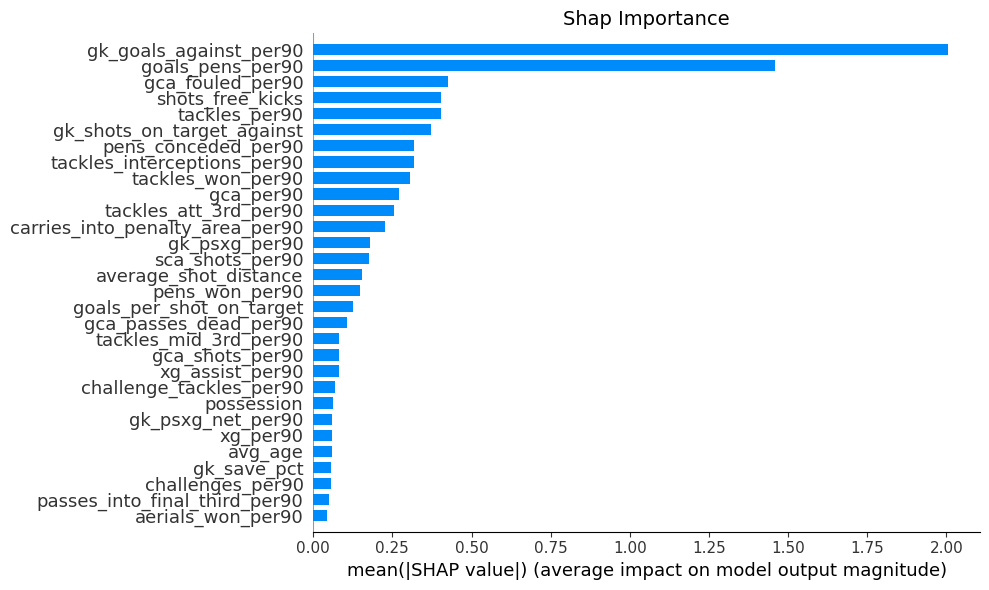

In [187]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=features.columns.to_list(), 
                    show=False, max_display=30)

fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.title("Shap Importance", fontsize=14, loc="center")   
plt.tight_layout()
plt.show()